## Solving Aiyagari using the Endogenous Grid Method

The goal of this note is to illustrate how to solve a standard incomplete market models (a la Aiyagari-Hugget) using the Endogenous Grid Method (EGM) and non-stochastic simulation. 

The Model is pretty standard. We want to solve the following Dynamic Programming problem for the household:

\begin{align}
V(a, s) &= \max_{a' \geq -\phi} \{u((1+r)a + w\exp{s} -a' ) + \beta\mathbb{E}[V(a', s')|s] \},
\end{align}

where $s$ follows an AR(1) process:

$s_t = \rho s_{t-1} + \sigma \varepsilon_t,$

where $\varepsilon \sim N(0, 1)$.

We must also solve for the invariant distribution, $\lambda(a,s)$ :

$\lambda (\mathcal{A} \times \mathcal{S})  = \int_{A \times S}  Q((a, s), \mathcal{A} \times \mathcal{S})) d \lambda,$ 


and the interest rate that clears the market:

$\int_{A\times S} a d\lambda(a,s) = K.$

### Numerical Implementation

The first step is to define the packages used in the code:

In [1]:
# P.S currently tested on 3.10.7 python version, but these are standard packages and should work well in other version as well.
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit, guvectorize # NUMBA speed up quite a lot, see the functions that have the decorator just above
from scipy.optimize import brentq  # root-finding routine

# Matplotlib par
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 12})

path = '/Users/tomasrm/Library/CloudStorage/Dropbox/Teaching/Insper/AdvancedMacro/Codes/Plots' # this is only used to save plots


The next block of codes define auxiliary functions. Rouwenhorst is a function used to discretize the labor process. The other two functions are used to do some fast linear interpolation.


In [2]:
def rouwenhorst(N, rho, sigma, mu=0.0):
    """Rouwenhorst method to discretize AR(1) process"""

    q = (rho + 1)/2
    nu = ((N-1.0)/(1.0-rho**2))**(1/2)*sigma
    s = np.linspace(mu/(1.0-rho)-nu, mu/(1.0-rho)+nu, N) # states

    # implement recursively transition matrix
    P = np.array([[q, 1-q], [1-q, q]])

    for i in range(2,N): # add one row/column one by one
        P = q*np.r_[np.c_[P, np.zeros(i)] , [np.zeros(i+1)]] + (1-q)*np.r_[np.c_[np.zeros(i), P] , [np.zeros(i+1)]] + (1-q)*np.r_[[np.zeros(i+1)] ,  np.c_[P, np.zeros(i)]] + q*np.r_[[np.zeros(i+1)] ,  np.c_[np.zeros(i), P]]
        P[1:i,:]=P[1:i,:]/2  # adjust the middle rows of the matrix

    return s, P


# I took this function from state-space Jacobian package
@guvectorize(['void(float64[:], float64[:], float64[:], float64[:])'], '(n),(nq),(n)->(nq)')
def interpolate_y(x, xq, y, yq):
    """Efficient linear interpolation exploiting monotonicity.
    Complexity O(n+nq), so most efficient when x and xq have comparable number of points.
    Extrapolates linearly when xq out of domain of x.
    Parameters
    ----------
    x  : array (n), ascending data points
    xq : array (nq), ascending query points
    y  : array (n), data points
    Returns
    ----------
    yq : array (nq), interpolated points
    """
    nxq, nx = xq.shape[0], x.shape[0]

    xi = 0
    x_low = x[0]
    x_high = x[1]
    for xqi_cur in range(nxq):
        xq_cur = xq[xqi_cur]
        while xi < nx - 2:
            if x_high >= xq_cur:
                break
            xi += 1
            x_low = x_high
            x_high = x[xi + 1]

        xqpi_cur = (x_high - xq_cur) / (x_high - x_low)
        yq[xqi_cur] = xqpi_cur * y[xi] + (1 - xqpi_cur) * y[xi + 1]

@guvectorize(['void(float64[:], float64[:], uint32[:], float64[:])'], '(n),(nq)->(nq),(nq)')
def interpolate_coord(x, xq, xqi, xqpi):
    """Get representation xqi, xqpi of xq interpolated against x:
    xq = xqpi * x[xqi] + (1-xqpi) * x[xqi+1]
    Parameters
    ----------
    x    : array (n), ascending data points
    xq   : array (nq), ascending query points
    Returns
    ----------
    xqi  : array (nq), indices of lower bracketing gridpoints
    xqpi : array (nq), weights on lower bracketing gridpoints
    """
    nxq, nx = xq.shape[0], x.shape[0]

    xi = 0
    x_low = x[0]
    x_high = x[1]
    for xqi_cur in range(nxq):
        xq_cur = xq[xqi_cur]
        while xi < nx - 2:
            if x_high >= xq_cur:
                break
            xi += 1
            x_low = x_high
            x_high = x[xi + 1]

        xqpi[xqi_cur] = (x_high - xq_cur) / (x_high - x_low)
        xqi[xqi_cur] = xi
        xqpi[xqi_cur] =  min(max(xqpi[xqi_cur],0.0), 1.0) # if the weight is outside 0 or 1, this will catch it


#### Parameters and Grids
The function below sets the values of some parameters and constructs the grid used to solve the model. 

The asset grid is defined using a function the assigns more curvature to smaller values of $a$:

$a_i = a_1 +  (a_{n_A} - a_1) \dfrac{(1+\nu)^{i-1} - 1}{(1+\nu)^{n_A-1} - 1} \qquad \text{for } i = 1, 2, ..., n_A.$

The labor grid is defined using Tauchen/Rouwenhorst method. Afterwise, we pre-compute the invariant distribution of the Markov Process and the aggregate labor supply (which is constant in this simple version of the model).

In [3]:
def setPar(
    nA = 300, # Asset grid size
	nS = 7,		# Labor endowment grid size
	alpha = 0.33,
	delta = 0.05,
	beta = 0.96,
	gamma = 2.0,	# CRRA parameter
    phi = 0.0,   # borrowing constraint
	rho = 0.9, # autocorrelation
	sigma = 0.1, # std deviation
	amax = 250.0, # maximum grid point
	grid_growth = 0.025  # asset grid curvature (growth rate between points)
    ):

	#### Define the labor grid
	gS, transS = rouwenhorst(nS, rho, sigma)
	gS = np.exp(gS)

	# compute invariant distribution of labor process (by iteration)
	invS = np.ones(nS) / nS # initial guess
	tol=1E-11; maxit=100^4
	for it in range(maxit):
		invS_new = invS @ transS
		if np.max(np.abs(invS_new - invS)) < tol: break  
		invS = invS_new

	Lbar = sum(invS*gS) # aggregate labor supply

	#### Define the asset grid:
	if grid_growth == 0.0: 
		gA = np.linspace(-phi, amax, nA)
	elif grid_growth > 0.0:
		gA = np.zeros(nA)
		for i in range(nA):
			gA[i]= -phi + (amax - (-phi))*((1 + grid_growth)**i -1)/((1 + grid_growth)**(nA-1.0) -1)
        
	# create dictionary with parameters
	param = {}
	param['alpha'] = alpha; param['delta'] = delta; param['beta'] = beta; param['gamma'] = gamma; param['beta'] = beta; param['phi'] = phi
	param['nA'] = nA; param['gA'] = gA
	param['nS'] = nS; param['gS'] = gS; param['transS'] = transS; param['Lbar'] = Lbar; param['invS'] = invS

	return param

param = setPar()
print(param)

{'alpha': 0.33, 'delta': 0.05, 'beta': 0.96, 'gamma': 2.0, 'phi': 0.0, 'nA': 300, 'gA': array([0.00000000e+00, 3.88789332e-03, 7.87298397e-03, 1.19577019e-02,
       1.61445378e-02, 2.04360445e-02, 2.48348390e-02, 2.93436032e-02,
       3.39650866e-02, 3.87021071e-02, 4.35575531e-02, 4.85343853e-02,
       5.36356382e-02, 5.88644225e-02, 6.42239264e-02, 6.97174179e-02,
       7.53482466e-02, 8.11198461e-02, 8.70357356e-02, 9.30995223e-02,
       9.93149037e-02, 1.05685670e-01, 1.12215705e-01, 1.18908991e-01,
       1.25769609e-01, 1.32801742e-01, 1.40009679e-01, 1.47397814e-01,
       1.54970653e-01, 1.62732813e-01, 1.70689026e-01, 1.78844145e-01,
       1.87203142e-01, 1.95771114e-01, 2.04553285e-01, 2.13555011e-01,
       2.22781779e-01, 2.32239217e-01, 2.41933091e-01, 2.51869311e-01,
       2.62053938e-01, 2.72493179e-01, 2.83193402e-01, 2.94161131e-01,
       3.05403052e-01, 3.16926022e-01, 3.28737066e-01, 3.40843386e-01,
       3.53252364e-01, 3.65971566e-01, 3.79008748e-01, 3.923

#### Endogenous Grid Method
The first part of the problem is to solve the household problem. We use the Endogenous Grid Method (Carroll (2005)) for that.

Note that our endogenous grid is on assets (some people use on income) and we iterate on the consumption policy function. There are many ways to do this: we can define the endogenous assets on cash-on-hand and iterate on the endogenous grid or in the asset policy function. They should yield the same results, but for some problems, one can be easier to implement than others.


In [4]:
def solveHHproblemEGM(param, r, w):
    # unpacking parameters
    nA = param['nA']; gA = param['gA']; nS = param['nS']; gS = param['gS']
    transS = param['transS']; beta = param['beta']; gamma = param['gamma']
    
    # Define parameters
    maxiter = 2000
    tol = 1E-11 # tolerance

    # Useful matrices
    gAA = np.repeat(gA, nS).reshape((nA, nS)) # nA x nS matrix of asset grid.
    gSS = np.repeat(gS, nA).reshape((nS, nA)).T # nA x nS matrix of labor grid. Note the transpose.
    gYY = w * gSS + (1.0 + r) * gAA # nA x nS matrix of cash on hand grid.

    # Pre-allocate value and policy funcctions
    cp = gYY - gAA  # consumption policy
    ap = np.zeros((nA, nS))   # asset policy
    endogAA = np.zeros((nA, nS))  # endogenous asset grid

    
    for iter in range(maxiter):
        # ===== Perform EGM ===== #
        expect = beta * (1.0 + r) * np.matmul( cp**(-gamma) , transS.T)  # Right hand side of Euler Eq.
        c = expect**(-1.0/gamma)    # Invert marginal util to get contemporaneous C
        endogAA = (c + gAA - w * gSS) / (1 + r)  # compute asset state on endogenous grid (note that gAA is the policy function, which is on-grid)  
        
        # === Interpolate to find the correct asset policy function
        apNew = np.zeros((nA, nS)) # here we store the policy function that we interpolate

        for iS in range(nS):
            interpolate_y(endogAA[:, iS], gA, gA, apNew[:, iS]) # perform interpolation
            # Must account for the binding constraint!
            for ia in range(nA):
                if apNew[ia, iS] < gA[0]: apNew[ia, iS] = gA[0]
                else: break  # exploit monotinicity of ia.

        cpNew = gYY - apNew  # get updated consumption policy

        # ===== Check if policuufunction has converged =====
        d = np.amax(np.abs(cp - cpNew))
        cp = cpNew
        ap = apNew

        #print("Iter: ", iter, "Tol. ", d)

        if d < tol:
            print(f"Tol. achieved (EGM): {d}")
            break  # break the loop in case we found the Policy Function!
    
        if iter == maxiter:
            print("Max iterations achieved. VF did not converge")

    return ap, cp, endogAA

dec = solveHHproblemEGM(param, 0.04, 1.0)
#print("ap ", dec[0])
#print("cp ", dec[1])
#print(dec[2])

Tol. achieved (EGM): 9.691802915767767e-12


#### Invariant Distribution

Once we have the policy functions, we can compute the stationary distribution of the associated policy functions. I will use the non-stochastic simulation on the histogram a la Young (2005). 

The distribution is defined as a histogram defined in the same grid as the policy function (it does NOT need to be like this, I am doing it just to simplify). Hence, $\lambda(a_i, s_j)$ is the mass of agents in state $(a_i, s_j)$. 

Since the policy function is usually off-grid, we allocate some agents in the grid below, and some in the grid above using an interpolation method.

Afterwise, we can just iterate forward until it converges.

Another way to solve for the invariant distribution is to construct the transition matrix between states (it is a matrix nA * nS x nA * nS). Then, find the invariant distribution of this Markov-Chain using standard methods. Usually, this method is a bit slower, but depending on the problem it may be useful.


In [5]:
@njit  # ps. using numba here is crucial, it speeds up quite a lot
def iterationDist(dsn, dsnNew, ibelow, iweight, transS): 
    nA, nS = dsn.shape
    for iA in range(nA):
        for iS in range(nS):
            if dsn[iA, iS] > 0:  # this speed a bit in some problems
                dsnNew[ibelow[iA, iS], iS] += iweight[iA, iS] * dsn[iA, iS]
                dsnNew[ibelow[iA, iS] + 1, iS] += (1-iweight[iA, iS]) * dsn[iA, iS]
    dsnNew = dsnNew @ transS   # apply the markov-chain of labor process
    return dsnNew


def solveInvariant(param, decisions):
    nA = param['nA']; gA = param['gA']; nS = param['nS']; transS = param['transS'];
    ap = decisions[0]

    # Define aux parameters:
    maxiterInv = 50000
    tolInv = 1e-10

    # === 1. RETRIEVE GRID AND WEIGHT OF INTERPOLATED POLICIES ============== #
    # ps. the interpolation assume that policy is monotone
    ibelow = np.zeros((nA, nS), dtype=int)
    iweight = np.zeros((nA, nS))

    for iS in range(nS):
        interpolate_coord(gA, ap[:,iS], ibelow[:,iS], iweight[:,iS])
        # iweight is probability agent ends in grid "ibelow".
        
    # ================ 2. ITERATE FORWARD DISTRIBUTION ======================== #
    dsn = np.ones((nA, nS)) / (nS*nA)  # initial guess, positive mass everywhere must sum to one

    for iter in range(maxiterInv):
        # compute next distribution
        dsnNew = np.zeros((nA, nS))
        dsnNew = iterationDist(dsn, dsnNew, ibelow, iweight, transS)

        # ===== Check if distribution has converged =====
        d = np.amax(np.abs(dsn - dsnNew))
        dsn = dsnNew  # update distribution

        #print("Iter: ", iter, "Tolerance: ", d)
        if d < tolInv:
            print("Tol. achieved (Inv. dist.): ", d)
            break

        if iter == maxiterInv-1:
            print("Max iterations achieved. Invariant distribution did not converge")

    return dsn

dsn=solveInvariant(param, dec)
#dsn

Tol. achieved (Inv. dist.):  9.984609840307801e-11


#### Excess Demand Funtion

Now that we have all the elements of the model, we construct an excess demand function: A function that takes a guess of interest and returns the difference between asset supply and capital demand. It does that in the following order:

1. Given the interest rate guess, compute the capital demand and the equilibrium wage using the first order conditions of the firm's problem.

2. Given the interest rate and the wage, solve the household problem.

3. Given the policy function computte the invariant distribution.

4. Aggregate the invariant distribution to compute aggregate savings. 

5. Compute the excess demand (aggregate savings minus capital demand).

In [6]:
def ExcessDemand(param, r):
    #unpack parameters
    Lbar = param['Lbar']; gA = param['gA']; alpha = param['alpha']; nS = param['nS']; delta = param['delta']

    # Compute Capital Demand and implied wage from the production function
    Kd = (alpha/(r+delta))**(1/(1-alpha))*Lbar # capital demand
    w = (1-alpha)*(Kd/Lbar)**alpha

    # Solve HH problem
    decisions = solveHHproblemEGM(param, r, w)

    # Compute Invariant distribution
    dsn = solveInvariant(param, decisions)

    # Compute Excess Demand of asset market
    gAA = np.repeat(gA[None,:], nS, axis=0).T # repeat columns of gA
    Ea = sum(sum(dsn*gAA)) # Aggregate asset supply
    excDem = (Ea -Kd)/((Ea+Kd)/2) # excess demand in percentage 

    return (excDem, decisions, dsn, w, Kd, Ea)

#ExcessDemand(param, r)

#### Solving the Model

Finally, we solve the model using an efficient bracketing algorithm: Brent's method. 

We know from the theory that the interest rate is bounded above by the interest rate of the complete market models and it is bounded below by (minus) the depreciation rate. Use these as the initial guess.


In [7]:
def model_solution(param):
    # Parameters
    r0 = 0.001  # lower bound guess (make sure excess demand is negative)
    r1 = 1/param['beta'] - 1  # upper bound guess (make sure excess demand is positive)

    tol_eq = 0.0001

    def obj_fct(r_guess):
        print("Interest Rate Guess: ", r_guess)
        results = ExcessDemand(param, r_guess)
        print("Excess Demand: ", results[0])
        return results[0]

    r = brentq(obj_fct, r0, r1, xtol=tol_eq)
    _, decisions, dsn, w, Kd, Ea = ExcessDemand(param, r)  # get the stuff from the model

    return decisions, dsn, w, r, Kd, Ea  # model stats

param = setPar()
(decisions, dsn, w, r, Kd, Ea) = model_solution(param)


Interest Rate Guess:  0.001
Tol. achieved (EGM): 8.498091119690798e-12
Tol. achieved (Inv. dist.):  9.081599361415726e-11
Excess Demand:  -1.935916006407903
Interest Rate Guess:  0.04166666666666674
Tol. achieved (EGM): 9.677592061052565e-12
Max iterations achieved. Invariant distribution did not converge
Excess Demand:  1.8447489167080888
Interest Rate Guess:  0.02182365206339644
Tol. achieved (EGM): 9.265477274311706e-12
Tol. achieved (Inv. dist.):  9.490401520206859e-11
Excess Demand:  -1.622087178444151
Interest Rate Guess:  0.0311079385673511
Tol. achieved (EGM): 9.606537787476555e-12
Tol. achieved (Inv. dist.):  9.913801030103642e-11
Excess Demand:  -1.0845367310346645
Interest Rate Guess:  0.03638730261700892
Tol. achieved (EGM): 9.72022462519817e-12
Tol. achieved (Inv. dist.):  9.992289287663603e-11
Excess Demand:  -0.31587505304589925
Interest Rate Guess:  0.0380393341174027
Tol. achieved (EGM): 9.919176591210999e-12
Tol. achieved (Inv. dist.):  9.958161725776016e-11
Excess De


Model Stats:

Eq. wage and interest rate: 1.2872  0.0377
Aggregate Capital and Asset Supply: 7.4249  7.4245
Labor Supply:  1.027
K/L:  7.232
Agg. Output:  1.972
A/Y:  3.764
Fraction of constrained households::  0.035

Wealth Distribution:
Avg. a:  7.425
Std. a:  6.805
p25  a:  2.106
p50  a:  5.581
p95  a: 20.659
p99  a: 29.097


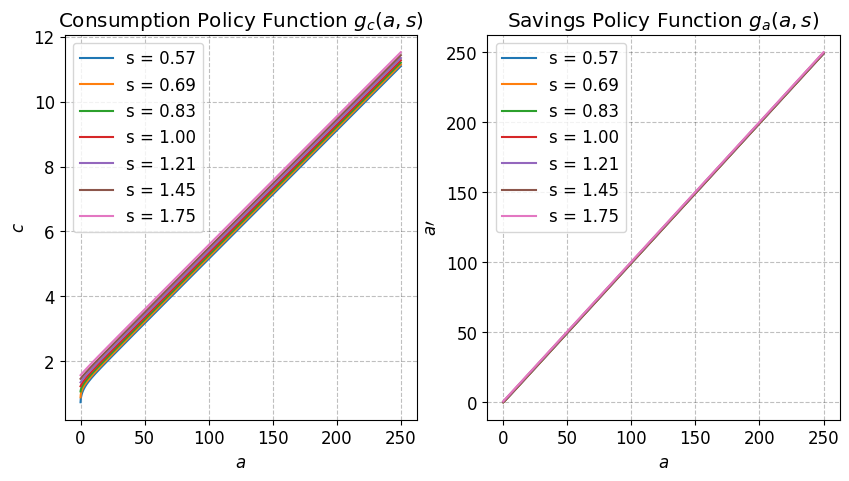

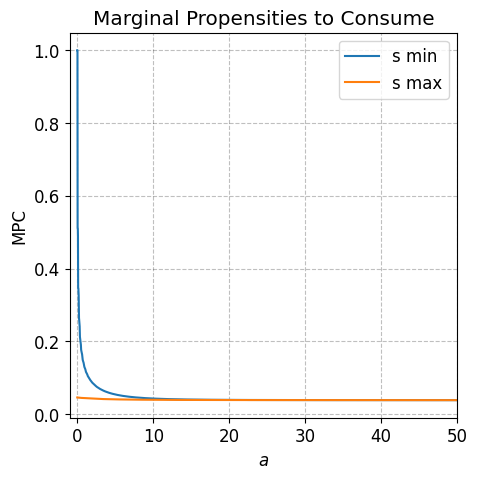

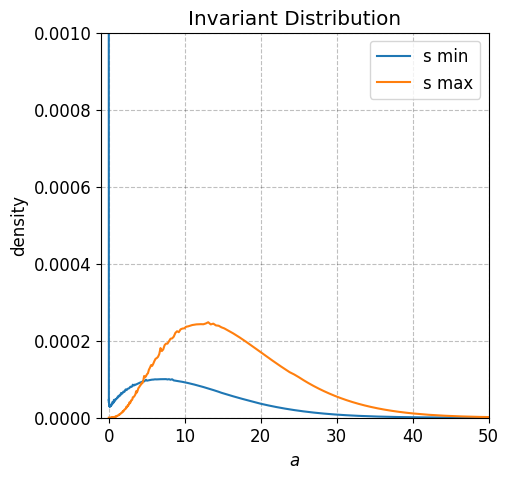

In [8]:
def ModelStats(param, decisions, dsn, w, r, Kd, Ea):
    alpha = param['alpha']; Lbar = param['Lbar']; nS = param['nS']; gS = param['gS']
    gA = param['gA']
    cp = decisions[1] # policy consumption
    ap = decisions[0] # policy savings
    
    # Compute useful stats
    Y = Kd**alpha * Lbar**(1-alpha)
    const_hh = sum(dsn[0,:])

   # Marginal propensity to consume 
    mg_c = (cp[1:,:] - cp[0:-1, :])
    mg_wealth = ((1+r)*(gA[1:]-gA[0:-1]))
    mg_wealth = np.repeat(mg_wealth[None,:], param['nS'], axis=0).T # repeat columns 
    mpc = mg_c/mg_wealth
    
    # Wealth distribution:
    dsn_a = np.sum(dsn,axis=1)
    cdf_a = np.cumsum(dsn_a)
    mean_a = np.sum(dsn_a*gA)
    std_a = np.sqrt(np.sum(dsn_a*(gA-mean_a)**2))

    def percentile(gA, cdf_a,p): # got this function from Jeppe Druedahl
        nA = len(gA)
    
        # a. check first
        if p < cdf_a[0]: return gA[0]
    
        # b. find with loop
        i = 0
        while True:
            if p > cdf_a[i+1]:
                if i+1 >= nA: raise Exception()
                i += 1
                continue
            else:
                w = (p-cdf_a[i])/(cdf_a[i+1]-cdf_a[i])
                diff = gA[i+1]-gA[i]
                return gA[i]+w*diff
        
    p25_a = percentile(gA,cdf_a,0.25)
    p50_a = percentile(gA,cdf_a,0.50)
    p95_a = percentile(gA,cdf_a,0.95)
    p99_a = percentile(gA,cdf_a,0.99)


    print("\nModel Stats:")
    print(f'\nEq. wage and interest rate: {w:6.4f}  {r:6.4f}')
    print(f'Aggregate Capital and Asset Supply: {Kd:6.4f}  {Ea:6.4f}')
    print(f'Labor Supply: {Lbar:6.3f}')
    print(f'K/L: {Kd/Lbar:6.3f}')
    print(f'Agg. Output: {Y:6.3f}')
    print(f'A/Y: {Ea/Y:6.3f}')
    print(f'Fraction of constrained households:: {const_hh:6.3f}')
	#print("Gini of Wealth:")
	#print("Gini of Income:")
	#print("Gini of Consumption:")
    print("\nWealth Distribution:")
    print(f'Avg. a: {mean_a:6.3f}')
    print(f'Std. a: {std_a:6.3f}')  
    print(f'p25  a: {p25_a:6.3f}')
    print(f'p50  a: {p50_a:6.3f}')
    print(f'p95  a: {p95_a:6.3f}')
    print(f'p99  a: {p99_a:6.3f}')

 
    # Plot policy function:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 5)) # Ax1 is consumption ax2 is savings

    for s in range(nS):
        ax1.plot(gA,cp[:,s],label=f's = {gS[s]:.2f}'  )
        ax2.plot(gA,ap[:,s],label=f's = {gS[s]:.2f}'  )

    ax1.legend(frameon=True)
    ax1.set_xlabel('$a$')
    ax1.set_ylabel('$c$')
    ax1.set_title('Consumption Policy Function $g_c(a,s)$')  

    ax2.legend(frameon=True)
    ax2.set_xlabel('$a$')
    ax2.set_ylabel('$a\prime$')
    ax2.set_title('Savings Policy Function $g_a(a,s)$')  
    #fig.tight_layout(pad=0.5)
    #plt.savefig(path + "/policy_func.png", bbox_inches='tight')
    
    # Plot MPCs:
    fig, ax1  = plt.subplots(1,1,figsize=(5, 5)) 
    ax1.plot(param['gA'][0:-1],mpc[:,0], label = "s min")
    ax1.plot(param['gA'][0:-1],mpc[:,-1], label = "s max")
    ax1.set_xlim([param['gA'][0]-1.0,50])
    #ax1.set_ylim([0.0, 0.001])

    ax1.set_xlabel('$a$')
    ax1.set_ylabel('MPC')
    ax1.legend(frameon=True)
    ax1.set_title('Marginal Propensities to Consume')
    #plt.savefig(path + "/mpc.png", bbox_inches='tight')

 
    # Plot densities:
    fig, ax1  = plt.subplots(1,1,figsize=(5, 5)) 
    ax1.plot(param['gA'],dsn[:,0], label = "s min")
    ax1.plot(param['gA'],dsn[:,-1], label = "s max")
    ax1.set_xlim([param['gA'][0]-1.0,50])
    ax1.set_ylim([0.0, 0.001])

    ax1.set_xlabel('$a$')
    ax1.set_ylabel('density')
    ax1.legend(frameon=True)
    ax1.set_title('Invariant Distribution')
    #plt.savefig(path + "/distribution.png", bbox_inches='tight')

    return


ModelStats(param, decisions, dsn, w, r, Kd, Ea)
